In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
from pathlib import Path
os.chdir("/content/drive/My Drive/Akarshan/BERT")
!ls -l

total 62833
-rw------- 1 root root  8388432 Dec 26 21:48  BERT5.hdf5
drwx------ 2 root root     4096 Dec  3 16:27  clr
-rw------- 1 root root   488019 Dec 26 22:59  Compare.ipynb
-rw------- 1 root root   476329 Dec 26 23:48 'copy EDA on results.ipynb'
-rw------- 1 root root   488019 Dec 28 17:32 'Copy of Compare.ipynb'
-rw------- 1 root root   255088 Dec 26 23:16 'Copy of Distllbert400000.ipynb'
drwx------ 2 root root     4096 Dec  3 16:27  Data
-rw------- 1 root root  8306584 Dec 24 07:57  DBert1hk.hdf5
-rw------- 1 root root 12719136 Dec 24 07:57  DBert4hk.hdf5
-rw------- 1 root root   251029 Dec 26 22:52  Distllbert400000.ipynb
-rw------- 1 root root   487917 Dec 27 00:17 'EDA on results.ipynb'
drwx------ 2 root root     4096 Dec 18 07:14 'misc model'
-rw------- 1 root root    42964 Dec 26 22:44  model.png
drwx------ 2 root root     4096 Dec  3 16:27  papers
-rw------- 1 root root  8306584 Dec 19 08:56  Rbert4.hdf5
-rw------- 1 root root    85578 Dec 26 22:54  Roberta.ipynb
-rw-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Dec 28 17:35:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!pip install pympler
!pip install tensorflow_addons

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 3.3 MB 54.6 MB/s 
     |████████████████████████████████| 596 kB 56.3 MB/s 
     |████████████████████████████████| 61 kB 514 kB/s 
     |████████████████████████████████| 895 kB 56.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 164 kB 5.1 MB/s 
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import numpy as np
import pickle
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pympler import asizeof
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import pipeline
from tensorflow.keras.layers import concatenate
from transformers import TFAutoModel, AutoTokenizer, AutoConfig,TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import ModelCheckpoint
from clr import clr_callback
import tensorflow_addons as tfa

In [ ]:
csvfile = 'Data//data.csv'
dropna = 'Data//datadropna.csv'
sent_data_file = 'Data//sent_data.csv'
label_file = 'Data//label.csv'
vocab_file = 'Data//vocab_tr_w.txt'

In [ ]:
df = pd.read_csv(dropna,usecols = ['SBE','Label'])
# df.dropna(inplace=True)
print(df.head())
print(df.shape)

   Label                                                SBE
0      1  To facilitate an easier notation throughout th...
1      0  Therefore _MATH_ defines a special order of ti...
2      0  This is important since only _MATH_ is the rea...
3      0  Note that in all contour time-integrals we ess...
4      0  Theorem _REF_ proves the equivalence of ensemb...
(1189321, 2)


### loading embeddings From Distillbert

In [ ]:
num = len(os.listdir('Data//embeddingBr//'))

with open('Data//embeddingBr//embeddings'+str(0),'rb') as f:
    dataD = pickle.load(f)
    
for idx in range(1,num):
    
  with open('Data//embeddingBr//embeddings'+str(idx),'rb') as f:
    mat = pickle.load(f)
    dataD=np.concatenate([dataD,mat],axis=0)

In [ ]:
np.shape(dataD)

(400000, 768)

In [ ]:
df =  df.iloc[:np.shape(dataD)[0],:]

In [ ]:
_, temp_text, _, temp_labels = train_test_split(dataD, df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Label'])

# we will use temp_text and temp_labels to create validation and test set
_, test_text, _, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)



test_labels = tf.keras.utils.to_categorical(test_labels)

test_data = tf.data.Dataset.from_tensor_slices((test_text))
test_data = test_data.shuffle(50000).batch(128)


##Performance of FineTuned Model on DistillBert embedding Trained on 4
400k data points


In [ ]:
from keras.models import load_model
model = load_model("BERT5.hdf5")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 768)]             0         
                                                                 
 dense_10 (Dense)            (None, 768)               590592    
                                                                 
 dropout_7 (Dropout)         (None, 768)               0         
                                                                 
 batch_normalization_9 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 batch_normalization_10 (Bat  (None, 768)              3072      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 128)               9843

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
y_pr_ts_all = model.predict(test_data)

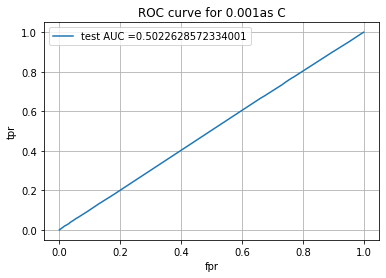

In [ ]:
y_pr_ts = y_pr_ts_all[:,0]
y_ts = test_labels[:,0]
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.22775831605267458 for threshold 0.718


Test Confusion Matrix


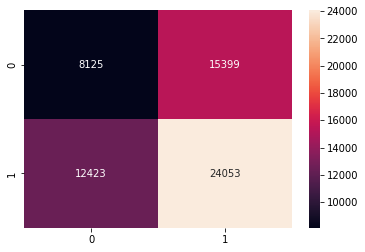

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 53.63%
Precision on test set: 60.97%
recall score on test set: 65.94%
f1 score on test set: 63.36%


#Performance of FineTuned Model on Robert embedding Trained on 400k datapoints


###Loading Embeddings form Roberta

In [ ]:
num = len(os.listdir('Data//embeddingRo//'))

with open('Data//embeddingRo//embeddings'+str(0),'rb') as f:
    dataR = pickle.load(f)
    
for idx in range(1,num):
    
  with open('Data//embeddingRo//embeddings'+str(idx),'rb') as f:
    mat = pickle.load(f)
    dataR=np.concatenate([dataR,mat],axis=0)

In [ ]:
asizeof.asizeof(dataR)/1024/1024/1024

2.2888184785842896

In [ ]:
np.shape(dataR)

(400000, 768)

In [ ]:
df =  df.iloc[:np.shape(dataR)[0],:]

In [ ]:
_, temp_text, _, temp_labels = train_test_split(dataR, df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Label'])

# we will use temp_text and temp_labels to create validation and test set
_, test_text, _, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)



test_labels = tf.keras.utils.to_categorical(test_labels)

test_data = tf.data.Dataset.from_tensor_slices((test_text))
test_data = test_data.shuffle(50000).batch(128)


In [ ]:
from keras.models import load_model
model = load_model("roBERT.hdf5")
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 768)]             0         
                                                                 
 dense_18 (Dense)            (None, 512)               393728    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 128)               65664     
                                                                 
 dropout_14 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 2)                 258       
                                                                 
Total params: 459,650
Trainable params: 459,650
Non-trainab

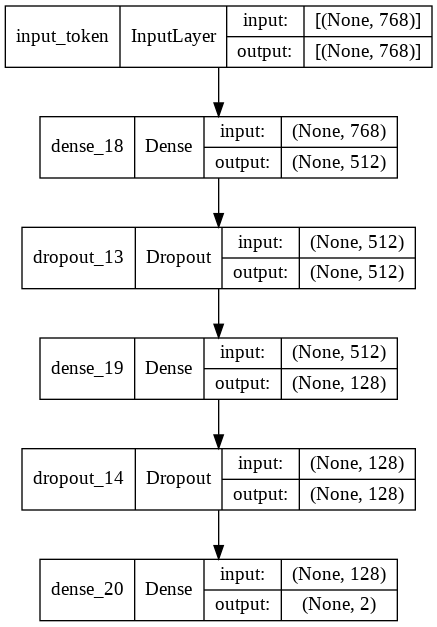

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
y_pr_ts_all = model.predict(test_data)

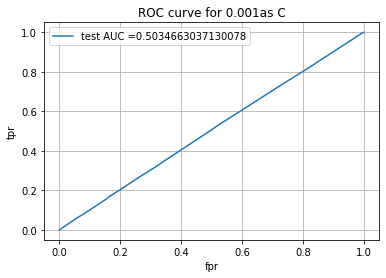

In [ ]:
y_pr_ts = y_pr_ts_all[:,0]
y_ts = test_labels[:,0]
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.25336011958976035 for threshold 0.678


Test Confusion Matrix


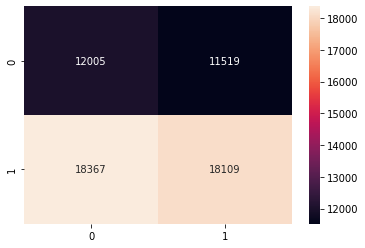

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 50.19%
Precision on test set: 61.12%
recall score on test set: 49.65%
f1 score on test set: 54.79%


#Performance of FineTuned Model on SciBert embedding Trained on 400k datapoints


###Loading Embeddings from Scibert

In [ ]:
num = len(os.listdir('Data//embeddingSb//'))

with open('Data//embeddingSb//embeddings'+str(0),'rb') as f:
    dataS = pickle.load(f)
    
for idx in range(1,num):
    
  with open('Data//embeddingSb//embeddings'+str(idx),'rb') as f:
    mat = pickle.load(f)
    dataS=np.concatenate([dataS,mat],axis=0)

In [ ]:
np.shape(dataS)

(400000, 768)

In [ ]:
asizeof.asizeof(dataS)

2457600128

In [ ]:
del dataR

In [ ]:
datay = df.iloc[:np.shape(dataS)[0],:]

In [ ]:
_, temp_text, _, temp_labels = train_test_split(dataS, datay['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=datay['Label'])

# we will use temp_text and temp_labels to create validation and test set
_, test_text, _, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)



test_labels = tf.keras.utils.to_categorical(test_labels)

test_data = tf.data.Dataset.from_tensor_slices((test_text))
test_data = test_data.shuffle(5000).batch(128)


In [ ]:
from keras.models import load_model
model = load_model("scBERT.hdf5")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 768)]             0         
                                                                 
 dense_14 (Dense)            (None, 512)               393728    
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 128)               65664     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 2)                 258       
                                                                 
Total params: 459,650
Trainable params: 459,650
Non-trainab

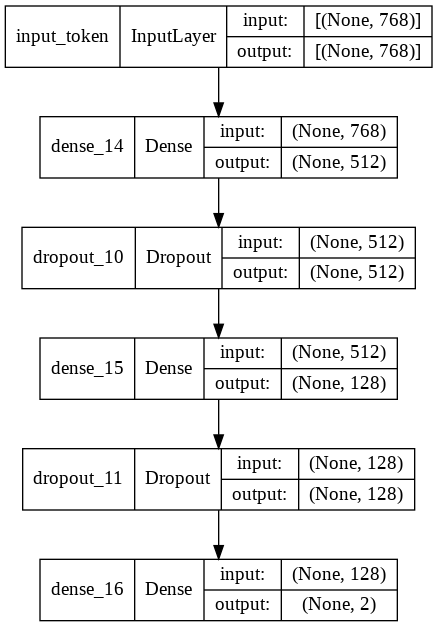

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
y_pr_ts_all = model.predict(test_data)

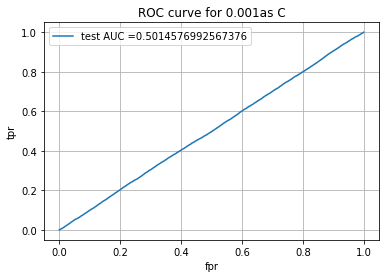

In [ ]:
y_pr_ts = y_pr_ts_all[:,0]
y_ts = test_labels[:,0]
from sklearn.metrics import roc_curve,auc,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

test_fpr, test_tpr, te_thresholds = roc_curve(y_ts, y_pr_ts)
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title('ROC curve for '+str (0.001)+'as C')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# This section of code where ever implemented is taken from sample kNN python notebook

def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions


print('test')
best_ts_thres = find_best_threshold(te_thresholds, test_fpr, test_tpr)

test
the maximum value of tpr*(1-fpr) 0.24883090420808848 for threshold 0.763


Test Confusion Matrix


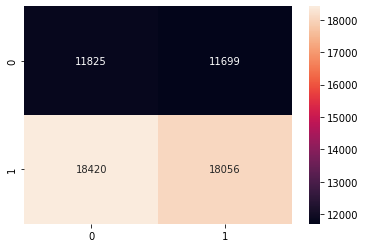

In [ ]:
print('Test Confusion Matrix')
cm2 = pd.DataFrame(confusion_matrix(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres)), range(2),range(2))
sns.heatmap(cm2, annot=True,fmt='g')

In [ ]:
acc=accuracy_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
ps=precision_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
rc=recall_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100
f1=f1_score(y_ts, predict_with_best_t(y_pr_ts, best_ts_thres))*100

print("Accuracy on test set: %0.2f%%"%(acc))
print("Precision on test set: %0.2f%%"%(ps))
print("recall score on test set: %0.2f%%"%(rc))
print("f1 score on test set: %0.2f%%"%(f1))

Accuracy on test set: 49.80%
Precision on test set: 60.68%
recall score on test set: 49.50%
f1 score on test set: 54.52%


##Comparison

In [ ]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "F1 score(%)"]
x.add_row(["DistillBert400k", "63.36"])
x.add_row(["Roberta", "54.79"])
x.add_row(["Scibert", "54.52"])

print(x)

+-----------------+-------------+
|      Model      | F1 score(%) |
+-----------------+-------------+
| DistillBert400k |    63.36    |
|     Roberta     |    54.79    |
|     Scibert     |    54.52    |
+-----------------+-------------+
